# Convolutional Neural Network Classifier

Today we will build convolutional neural network to classify pets using the Oxford pet dataset.

Load the data - this is a pytorch built-in test dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, ToPILImage, Compose, CenterCrop, Resize
import matplotlib.pyplot as plt

# Transforms
img_to_tensor = ToTensor()
tensor_to_img = ToPILImage()
crop = CenterCrop(360)        # crop all images to same size (360 x 360)
resize = Resize(128)          # resize so images are smaller / computationally cheaper

# the Oxford pet dataset is labelled by 37 breeds of cats and dogs, but we 
# will use the dataset to predict species cat (0) or dog (1) 
# manually define transform to convert breed id (1-37) to species id (0/1)
cat_breed_ids = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

def breed2species(breedid):
    if breedid in cat_breed_ids:
        return 0
    else:
        return 1

data = datasets.OxfordIIITPet(
    root="./",
    download=True,
    target_types = "category",
    transform=Compose([img_to_tensor, crop, resize]),
    target_transform=breed2species
)

/Users/lauraman/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/lauraman/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

In [2]:
len(data)

3680

## Set up
Split data

In [3]:
training_data, validation_data, test_data = torch.utils.data.random_split(data, lengths=[0.8, 0.1, 0.1])

In [4]:
training_data[10][1]

/Users/lauraman/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1

0


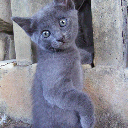

In [5]:
X, y = training_data[1120]
print(y)
tensor_to_img(X)

In [6]:
y

0

In [7]:
X.shape

torch.Size([3, 128, 128])

Preprocess the dataset
Split into training, validation and testing dataset

In [8]:
# Train, valid, test

In [9]:
# Create our dataloaders

In [10]:
dataloader = torch.utils.data.DataLoader(training_data, 
                                         shuffle=True,
                                         batch_size=128)
dataloader_validation = torch.utils.data.DataLoader(validation_data, 
                                         shuffle=True,
                                         batch_size=64)

In [11]:
len(training_data), len(validation_data)

(2944, 368)

0


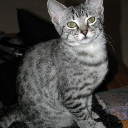

In [12]:
X_batch, y_batch = next(iter(dataloader))
print(y)
tensor_to_img(X_batch[0])

## Convolutions
We will create a convolutional network with 3 layers. First, explore what the convolutions are doing. 

Here is our first convolutional layer, that includes our convolution, RELU, BatchNorm and Pooling. Its good to check the size of the tensor.
Look at the docs here: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
Always need in_channels, out_channels, and kernel_size. You can also define stride and padding. Try some different choices and compare what the output shape is like. Explore what some output looks like for a few different channels


In [13]:
conv_layer_1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3, 
                      out_channels=3, 
                      kernel_size=3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

torch.Size([128, 3, 63, 63])


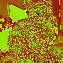

In [14]:
X_test_conv = conv_layer_1(X_batch)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])

Notice the size of our tensor has changed: its smaller because of the convolution and pooling. We can see some features from the convolution, that highlight regions of the image where the gradient is quickly changing, which shows us outlines of objects in the image. For the second convolutional layer, we will use the same structure.

In [15]:
conv_layer_2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

In [16]:
X_test_conv = conv_layer_2(X_test_conv)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])

torch.Size([128, 3, 30, 30])


In [17]:
conv_layer_3 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

In [18]:
X_test_conv = conv_layer_3(X_test_conv)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])

torch.Size([128, 3, 14, 14])


Lastly, we will pass our tensor through a fully connected linear layer to get our output. Our tensor is currently 3 channels by 14 in height and 14 in width, so we need to flatten this before it can go into a linear layer. The number of features going into the linear layer is 3 x 14 x 14 and the number of outputs is 1.

In [19]:
classifier = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=3*14*14, out_features=1),
      torch.nn.Sigmoid())

In [20]:
classifier(X_test_conv).shape

torch.Size([128, 1])

## Create model 
Create a convolutional neural network classifier.

In [21]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create CNN in layers
        self.conv_layer_1 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=3, 
                          out_channels=3, 
                          kernel_size=3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(3),
          torch.nn.MaxPool2d(2))
        self.conv_layer_2 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels = 3,
                          out_channels = 3,
                          kernel_size = 3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(3),
          torch.nn.MaxPool2d(2))
        self.conv_layer_3 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels = 3,
                          out_channels = 3,
                          kernel_size = 3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(3),
          torch.nn.MaxPool2d(2))
        
        
        self.classifier = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(in_features=3*14*14, out_features=1),
          torch.nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x


In [22]:
# Create an instance of SimpleNet and check we can call the function .forward on our first batch
my_network = ConvNet()
pred_batch = my_network(X_batch)
# Check the output is the correct size
print(pred_batch.shape)
#assert(pred_batch.shape == y_batch.shape)

torch.Size([128, 1])


In [23]:
#pred_batch, y_batch.reshape(-1, 1)

## Set up loss function and optimiser
Decide on a suitable loss function for a classifier.

We will use CrossEntropy. 

In [24]:
loss_function = torch.nn.BCELoss()
loss = loss_function(pred_batch.squeeze(), y_batch.float())
loss

tensor(0.7200, grad_fn=<BinaryCrossEntropyBackward0>)

In [25]:
y_batch

tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1])

In [26]:
#pred_batch, y_batch

And we also need to set up our optimiser and provide our network parameters

In [27]:
num_params = sum( sum(p.size()) for p in my_network.parameters())
num_params

653

In [28]:
optimiser = torch.optim.SGD(params = my_network.parameters(), lr=0.1)
optimiser = torch.optim.Adam(params = my_network.parameters())

## Training loop 
Start the training loop - it will look similar to our training loop from this morning. You can expect it to take several minutes to run - that's why its always sensible to check you can run a smaller version of it first with a subset of the data. 

In [29]:
import datetime
training_losses = []
validation_losses = []
num_epochs = 10

print(datetime.datetime.now())
for epoch in range(num_epochs):
    my_network.train()
    training_loss = 0
    for X_batch, y_batch in dataloader:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch.squeeze(), y_batch.float())
        loss.backward()

        # Update optimiser
        optimiser.step()
        
        # Add loss to training_loss
        training_loss += loss.item()
        
    # Add MSE losses to our list for plotting
    training_loss = training_loss / len(dataloader)
    training_losses.append(training_loss)

    # validation
    my_network.eval()
    validation_loss = 0
    for X_batch, y_batch in dataloader_validation:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch.squeeze(), y_batch.float())
        # Add loss to validation_loss
        validation_loss += loss.item()
        
    
    # Add MSE losses to our list for plotting
    validation_loss = validation_loss / len(dataloader_validation)
    validation_losses.append(validation_loss)
    
    # After every  epoch print mean losses
    if epoch%1 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")
print(datetime.datetime.now())


2024-11-15 09:49:54.076014
After epoch 0: Training loss=0.63, validation loss=0.80
After epoch 1: Training loss=0.59, validation loss=0.68
After epoch 2: Training loss=0.57, validation loss=0.61
After epoch 3: Training loss=0.56, validation loss=0.61
After epoch 4: Training loss=0.54, validation loss=0.60
After epoch 5: Training loss=0.53, validation loss=0.60
After epoch 6: Training loss=0.53, validation loss=0.62
After epoch 7: Training loss=0.52, validation loss=0.61
After epoch 8: Training loss=0.51, validation loss=0.60
After epoch 9: Training loss=0.50, validation loss=0.59
2024-11-15 09:52:31.004099


In [30]:
training_losses, validation_losses

([0.634448590485946,
  0.5911310444707456,
  0.5706293738406637,
  0.5579934949460237,
  0.5436338976673458,
  0.5344021229640298,
  0.5251331134982731,
  0.5172081019567407,
  0.5067444663980732,
  0.5041132608185643],
 [0.8002142508824667,
  0.683720330397288,
  0.611624558766683,
  0.6085559924443563,
  0.6023328800996145,
  0.6044082542260488,
  0.6219326059023539,
  0.6070969104766846,
  0.6025184392929077,
  0.5886991719404856])

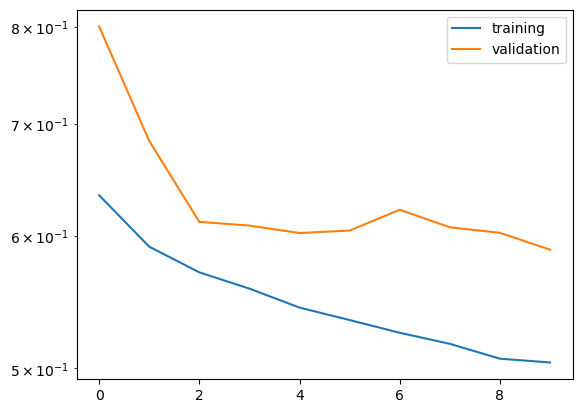

In [31]:
fig, ax = plt.subplots(1, 1)
plt.plot(training_losses, label="training")
plt.plot(validation_losses,  label="validation")
plt.legend()
ax.set_yscale('log')

## Results

In [32]:
def convert_binary(pred_batch):
    return torch.where(pred_batch > 0.5, 1.0, 0.0)

def label(y):
    if y < 0.5:
        return "cat"
    elif y > 0.5:
        return "dog"

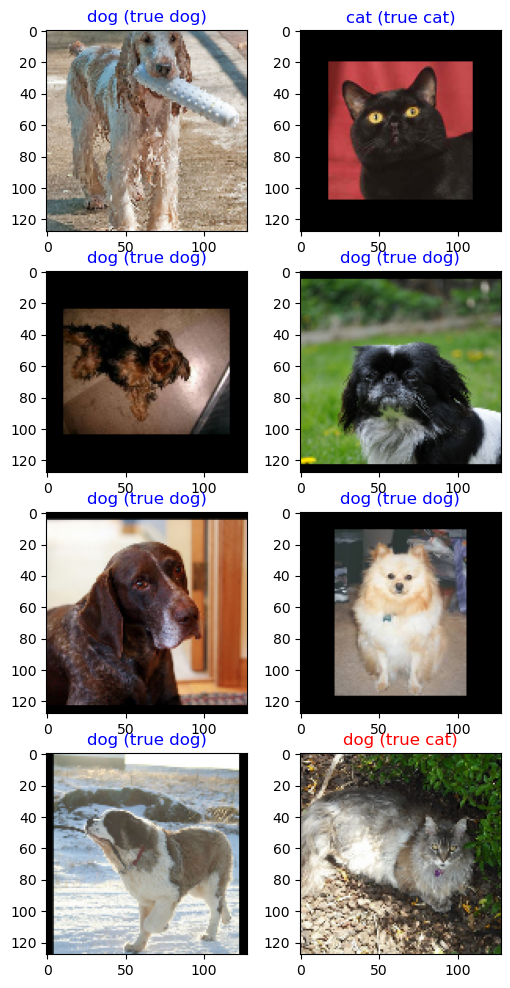

In [34]:
X_batch, y_batch = next(iter(dataloader_validation))
pred_batch = my_network(X_batch)
fig, axs = plt.subplots(4, 2, figsize=(6, 12))
axs = axs.flatten()

for i in range(8):
    y_label = label(y_batch[i])
    pred_label = label(pred_batch[i])
    axs[i].imshow(tensor_to_img(X_batch[i]))
    axs[i].set_title(f"{pred_label} (true {y_label})", 
                     color="blue" if pred_label is y_label else "red")

Congratulations! You've built your own cat/dog classifier. Now try and improve upon it with more data. You could also try and predict the breed. 

### Check convolutional layers
What are the convolutional layers doing after training?


In [ ]:
X_batch, y_batch = next(iter(dataloader_validation))

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
axs[0].imshow(tensor_to_img(X_batch[0]))
X_conv = my_network.conv_layer_1(X_batch)
axs[1].imshow(tensor_to_img(X_conv[0]))
X_conv = my_network.conv_layer_2(X_conv)
axs[2].imshow(tensor_to_img(X_conv[0]))
X_conv = my_network.conv_layer_3(X_conv)
axs[3].imshow(tensor_to_img(X_conv[0]))
print(my_network.classifier(X_conv)[0])
